In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Add, BatchNormalization, LeakyReLU,concatenate,PReLU,ELU
from keras.optimizers import Adam
import keras.backend as K

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
encoding_size = 128
perturbation_max = 40
smooth = 1.

In [3]:
pOCTImage = '896x896_4um_4_prozess0000.tif'
#pOCTImage = 'oct.tif'

# Preprocessing

In [9]:
preprocess = lambda x : x / 127 - 1
deprocess  = lambda x :((x + 1) * 127).astype(np.uint8)

In [10]:
def soft_dice(y_pred, y_true):
    # y_pred is softmax output of shape (num_samples, num_classes)
    # y_true is one hot encoding of target (shape= (num_samples, num_classes))
    intersect = K.sum(y_pred * y_true, 0)
    denominator = K.sum(y_pred, 0) + K.sum(y_true, 0)
    dice_scores = K.constant(2) * intersect / (denominator + K.constant(1e-2)) # used to be 1e-6
    return dice_scores

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def soft_dice_loss(y_true, y_pred):
    return -soft_dice(y_true, y_pred)

In [11]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    minval = arr[...].min()
    maxval = arr[...].max()
    if minval != maxval:
        arr[...] -= minval
        arr[...] *= (255.0/(maxval-minval))
    return arr

In [16]:
img = normalize(np.array(PIL.Image.open(pOCTImage)))
img = img[0:512,0:800]
img = img[...,np.newaxis]
image_shape = img.shape
preproc_img = preprocess(img)
#plt.imshow(deprocess(preproc_img))
print(str(img.shape))

(512, 800, 1)


(512, 800, 1)


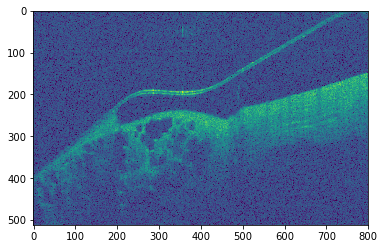

In [17]:
#corruption = np.random.randint(-perturbation_max, perturbation_max, size = image_shape)
corrupted_img = img.clip(0, 255)
#preproc_corrupted_img = preprocess(corrupted_img)
#print(str(np.max(preproc_corrupted_img)))
plt.imshow(np.squeeze(deprocess(preproc_img)))
print(image_shape)

# Setup our model

In [18]:
#act = LeakyReLU()
act = ELU()
#act = PReLU(shared_axes=[1, 2])
noFeatures = 8
noFilters = 3
model_input = Input(shape = image_shape)
layers = [model_input]
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
us4_concat = (layers[-1])
layers.append(AveragePooling2D()(layers[-1]))

# DS1
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
us3_concat = (layers[-1])
layers.append(AveragePooling2D()(layers[-1]))

# DS2
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
us2_concat = (layers[-1])
layers.append(AveragePooling2D()(layers[-1]))

# DS3
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
us1_concat = (layers[-1])
layers.append(AveragePooling2D()(layers[-1]))

# ENCODING
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Dropout(0.5)(layers[-1]))

# US1
layers.append(UpSampling2D(size = (2, 2))(layers[-1]))
layers.append(concatenate([layers[-1], us1_concat]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))

# US2
layers.append(UpSampling2D(size = (2, 2))(layers[-1]))
layers.append(concatenate([layers[-1], us2_concat]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))

# US3
layers.append(UpSampling2D(size = (2, 2))(layers[-1]))
layers.append(concatenate([layers[-1], us3_concat]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))

# US4
layers.append(UpSampling2D(size = (2, 2))(layers[-1]))
layers.append(concatenate([layers[-1], us4_concat]))
layers.append(Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))
layers.append(Convolution2D(1, 1, padding = 'same', activation = act, kernel_initializer = 'he_normal')(layers[-1]))

autoencoder = Model(layers[0], layers[-1])
#autoencoder.summary()

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\keras\activations.py:103: UserWarning: Do not pass a layer instance (such as ELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


# Fit Autoencoders with certain metrics

In [20]:
i2 = preproc_img[np.newaxis,...]

In [21]:
fit_params = {
    'x': i2,
    'y': i2,
    'epochs': 100,
    'batch_size': 1,
    'verbose': 0
}

# Mean Squared Error

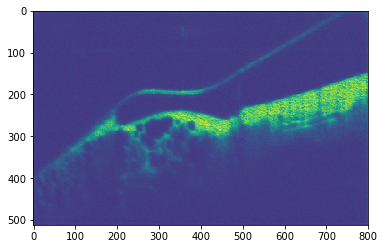

In [23]:
autoencoder.compile(Adam(1e-4), loss = 'mse')
fit_params = {
    'x': i2,
    'y': i2,
    'epochs': 100,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(i2)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_denoisingAE_mse_f8_1e4_do_elu.tif')
final_img = Image.fromarray(np.squeeze(np. uint8(normalize(deprocess(preproc_img)))))
final_img.save('octWhole_raw.tif')

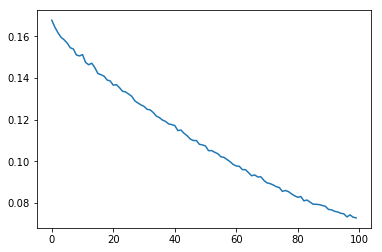

In [24]:
plt.plot(hist.history['loss'])

# Mean Absolute Error

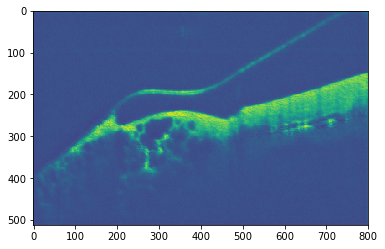

In [25]:
autoencoder.compile(Adam(1e-4), loss = 'mae')
fit_params = {
    'x': i2,
    'y': i2,
    'epochs': 100,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(i2)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_denoisingAE_mae_f8_1e4_do_elu.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(i2)))))
final_img.save('oct_raw.tif')

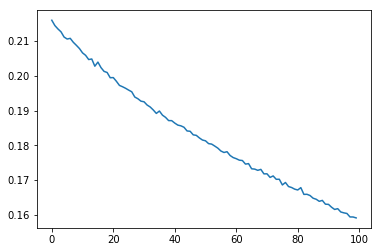

In [26]:
plt.plot(hist.history['loss'])

# Soft Dice

Instructions for updating:
keep_dims is deprecated, use keepdims instead


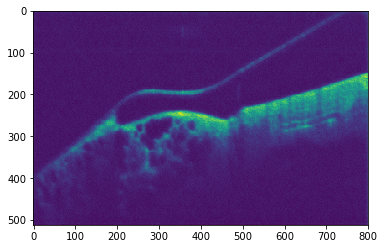

In [27]:
autoencoder.compile(Adam(1e-4), loss = soft_dice)
fit_params = {
    'x': i2,
    'y': i2,
    'epochs': 100,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(i2)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
#MAE@10-3
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_denoisingAE_sd_f8_100_do__.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(i2)))))
final_img.save('oct_raw.tif')

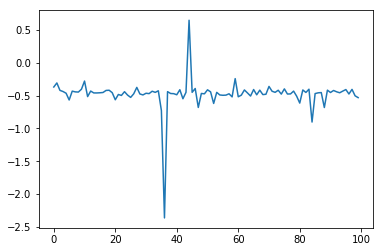

In [28]:
plt.plot(hist.history['loss'])